## Realising a Indipendent Multi Ouptup GP in PyMC ##
I'm having problems realising a Multi Output GP in PyMC.<br>
For the purposes of this Notebook data is generated with underlying funcions. I have multiple quantities I want to realise in a Multi-Output-Gaussian-Process (MOGP). I have found two ways (correlated) MOGPs are constructed. <br/>
As a vector-valued function <br> $\left(\begin{array}{c} f_1 \\ f_2 \end{array}\right) \sim GP\left(\left(\begin{array}{c} m_1 \\ m_2 \end{array}\right),\left(\begin{array}{c c} k | k \\ \hline k  |k \end{array}\right)\right)$ <br/> or as a GP operation on an extended input space with a categorical kernel <br>$f \sim GP(m, k(x,x')*k(i,i'))$.<br> (Based on [this blog by Invena](https://invenia.github.io/blog/2021/02/19/OILMM-pt1/#fn:1)) </br>
I have however not found a way to implement the vector-valued function in PyMC or to model the additional kernel. <br>
For now i would be happy if the MOGP handles the data as uncorrelated, so the off diagonal blocks in the vector-valued version would be zero or the categorical is $k(i,i')=0 $ if $i \neq i'$ and $k(i,i')=1$ if $i=i'$. <br>
I came to the conclusion, that a kernel in the form of the kroneker delta would be suitable for the categorical kernel, however i have not found a way to implement my "own" kernel, since no kroneker delta kernel is given by PyMC (atleast i haven't found one). I have found [this](https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/gaussian_process.html) for numpy kernels, but i couldn't make sense for it in the context of GPs. <br>
For the vector-valued MOGP it would make sense to use the coregion kernel with $B = \left(\begin{array}{c c} 1 & 0 \\ 0 & 1 \end{array} \right)$ and take the kroneker product with the existing kernel. <br>
$K(x,x') = k(x,x') \bigotimes B$. <br>
Again I was not succesfull in implementing this in PyMC. See the cells below for more information.<br>
I have found two threads on this forum regarding MOGPs [here](https://discourse.pymc.io/t/multiple-uncertain-function-observations-of-the-same-gaussian-process/400?u=junpenglao) and [here](https://discourse.pymc.io/t/multi-output-gaussian-processes/402), however i would like to model with a "true" GP and the kernels.
Is there a established way to model MOGPs in PyMC4? Which of the two ways would you say is more sensible: vector-valued function or categorical kernel. The vector-valued approch suffers from problems with dimension and i have not found a way to model the categorical kernel?<br> 
The use case is for interpolation, not extrapolation. I asked myself if the there is anything to learn by taking cross-variances into consideration? Especialy since the data is isotopic (after [Alvarez](https://arxiv.org/abs/1106.6251)), meaning that for every input x I have all the data y.
I am very thankfull for any ideas, comments, discussions and help.

In [3]:
###import 
from pathlib import Path
from copy import deepcopy
from dataclasses import dataclass, field

import pymc as pm
#import pymc.sampling_jax as pmjax
import numpy as np
import arviz as az
import aesara.tensor as at
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


### Generate data of different fidelitys
<p>In the following cell data is generated with two underlying functions func1 & func2. The generated data is than impinged with three different magnitudes of random values so simulate data from different sources of different fidelity. </p>
<p>The data is placed in a pandas DataFrame and categorized with High/Middle/Low Fidelity. Each category of fidelity is identified by a ID (0: Low, 1: Middle, 2:High) </p>
<p>The plot shows the data of differing fidelity</p>

    x_train       y_1       y_2       category  ID
0       4.0 -0.098172  1.194937   Low Fidelity   0
1       8.0  1.588037 -0.334234   Low Fidelity   0
2      12.0  2.184120  0.338095   Low Fidelity   0
3      16.0  1.560038  0.101703   Low Fidelity   0
4      20.0  2.026737 -0.032299   Low Fidelity   0
..      ...       ...       ...            ...  ..
67     80.0 -1.222977 -0.679915  High Fidelity   2
68     84.0 -0.844267 -0.504129  High Fidelity   2
69     88.0 -0.239814  0.076857  High Fidelity   2
70     92.0  0.293217  0.374469  High Fidelity   2
71     96.0  0.897851  0.852649  High Fidelity   2

[72 rows x 5 columns]


<AxesSubplot: xlabel='x_train'>

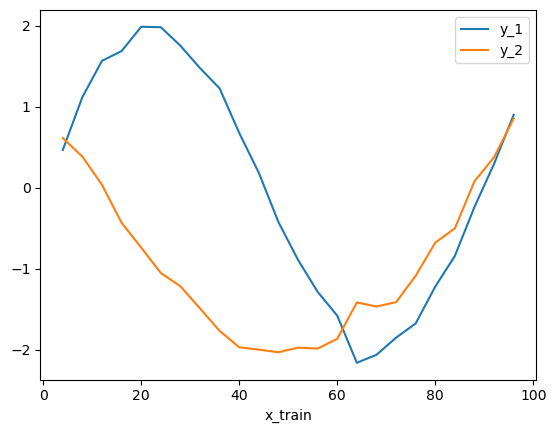

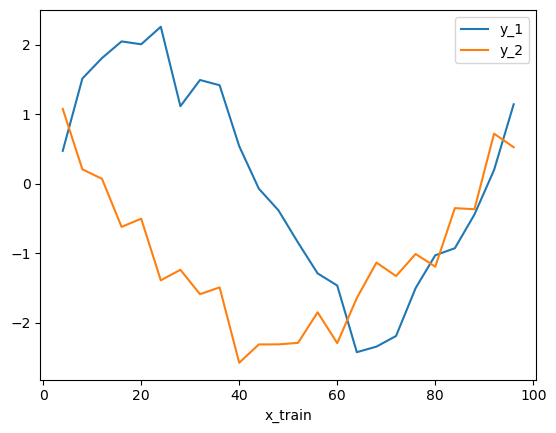

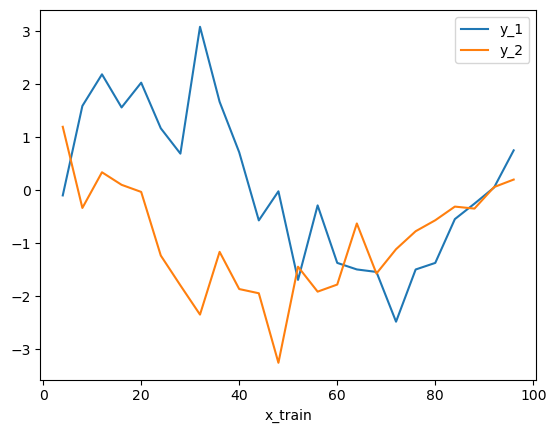

In [4]:
### define functions and create data
n_points=24

x_train=np.linspace(4,96,n_points)
x_predict=np.linspace(0,100,101)


func1 = np.sin(x_train[:n_points]*2*np.pi/90)*2
func2 = ((x_train-50)**2 /750 -2)

y_train = np.vstack([func1,func2])
y_train = y_train+ np.random.randn(*y_train.shape)*0.1
data=np.vstack([x_train,y_train])

df_hf= pd.DataFrame(data.T,columns=['x_train','y_1','y_2'])
df_hf.insert(3,'category','High Fidelity',allow_duplicates=False)

y_train += np.random.randn(*y_train.shape)*0.3
data= np.vstack([x_train,y_train])
df_mf=pd.DataFrame(data.T, columns=['x_train','y_1','y_2'])
df_mf.insert(3,'category','Middle Fidelity',allow_duplicates=False)

y_train += np.random.randn(*y_train.shape)*0.5
data = np.vstack([x_train, y_train])
df_lf=pd.DataFrame(data.T, columns=['x_train','y_1','y_2'])
df_lf.insert(3,'category','Low Fidelity',allow_duplicates=False)

df_train = pd.concat([df_lf, df_mf, df_hf],ignore_index=True)

df_train['category'] = (df_train['category']).astype('category')
df_train['category'] = df_train['category'].cat.reorder_categories(['Low Fidelity','Middle Fidelity','High Fidelity'],ordered=True)
df_train['ID'] = df_train['category'].cat.codes


df_predict = pd.merge(pd.RangeIndex(0,100,1).to_series(name='x_pred'),pd.Series(df_train['category'].cat.categories.factorize()[0],name='ID'), how='cross')


print(df_train)
#df_train.plot(x=['x_train','x_train'],y=['y_1','y_2'],kind='scatter')
#df_train.loc['category'=='High Fidelity'].plot(x='x_train',y='y_1',kind='scatter', label='y_1')
colors = {'High Fidelity': 'r', 'Middle Fidelity': 'b', 'Low Fidelity': 'g'}
df_train.loc[df_train['category']=='High Fidelity'].plot(x='x_train',y=['y_1','y_2'])
df_train.loc[df_train['category']=='Middle Fidelity'].plot(x='x_train',y=['y_1','y_2'])
df_train.loc[df_train['category']=='Low Fidelity'].plot(x='x_train',y=['y_1','y_2'])

### Model Building for one output
With the data in df_train a model is build. The model takes the different fidelitys into consideration by a coregion kernel with the corresponding sigma on the diagonal (line 39). <br>
This is functional with the $input_{dimension}=2$ and samples correctly (to my understanding). The problem arises once I try to expand the $output_{dimension} > 1$. See the next cell.

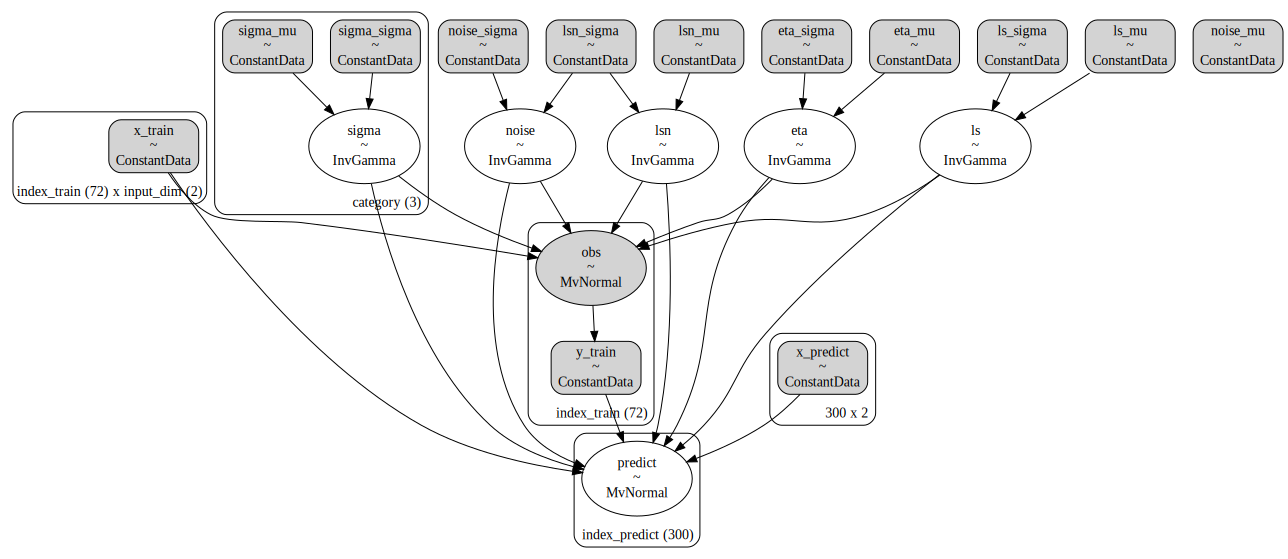

In [5]:
coords={
    'index_train':df_train.index,
    'index_predict':df_predict.index,
    'category':df_train['category'].cat.categories,
    'input_dim':['x_train','ID'],
    'output_dim':['y_1']
}
with pm.Model(coords=coords) as model_train:
    # Data
    x_train = pm.ConstantData('x_train', df_train[['x_train','ID']], dims=('index_train','input_dim'))
    y_train = pm.ConstantData('y_train', df_train['y_1'], dims=('index_train'))

    # Hyperparameter Prior
    sigma_mu = pm.ConstantData('sigma_mu', [3, 1, 0.2], dims='category')
    sigma_sigma = pm.ConstantData('sigma_sigma', [2, 0.5, 0.1], dims='category')
    sigma = pm.InverseGamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims='category')

    eta_mu = pm.ConstantData('eta_mu', 25)
    eta_sigma = pm.ConstantData('eta_sigma', 20)
    eta = pm.InverseGamma('eta', mu=eta_mu, sigma=eta_sigma)

    ls_mu = pm.ConstantData('ls_mu', 0.6)
    ls_sigma = pm.ConstantData('ls_sigma', 0.3)
    ls = pm.InverseGamma('ls', mu=ls_mu, sigma=ls_sigma)

    lsn_mu = pm.ConstantData('lsn_mu', 0.15)
    lsn_sigma = pm.ConstantData('lsn_sigma', 0.1)
    lsn = pm.InverseGamma('lsn', mu=lsn_mu, sigma=lsn_sigma)
    
    noise_mu = pm.ConstantData('noise_mu', 1e-1)
    noise_sigma = pm.ConstantData('noise_sigma', 8e-2)
    noise = pm.InverseGamma('noise', mu=noise_mu, sigma=noise_sigma) + 1e-4

    # Mean & Covariance Functions
    cov = cov = (eta**2
        * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)
        + pm.gp.cov.Coregion(input_dim=2, W=at.zeros_like(sigma),kappa=sigma, active_dims=[1])**2
        * pm.gp.cov.Matern52(input_dim=2, ls=lsn))
    
    #coregion = pm.gp.cov.Coregion(input_dim=1, B=at.eye(2))
    mean = pm.gp.mean.Zero()

    # Marginal GP Likehood
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)
    #obs = gp.marginal_likelihood('obs', X=x_train, y=y_train, sigma=noise, dims=('index_train','output_dim'))
    obs = gp.marginal_likelihood('obs', X=x_train, y=y_train, sigma=noise, dims=('index_train'))

with deepcopy(model_train) as model_predict:
    #Conditional GP Prediction
    x_predict= pm.ConstantData('x_predict', df_predict[['x_pred','ID']], dim=('index_predict', 'input_dim'))
    predict = gp.conditional('predict', Xnew=x_predict, pred_noise=True, dims=('index_predict'))

pm.model_to_graphviz(model_predict)

### Tries to realise a Multi-Output-Gaussian-Process (MOGP)
I have found two threads on this forum regarding MOGPs [here](https://discourse.pymc.io/t/multiple-uncertain-function-observations-of-the-same-gaussian-process/400?u=junpenglao) and [here](https://discourse.pymc.io/t/multi-output-gaussian-processes/402). However I want to realise the implementation with a "true" GP, although I'm up for discussion if this is the right way.
 I have read some blog posts about MOGPS from [Andy Jones](https://andrewcharlesjones.github.io/journal/lmc.html) and [Ivenia Blog](https://invenia.github.io/blog/2021/02/19/OILMM-pt1/#fn:1)<br>
 The next two cells are my tries to realise a vector-valued function.

#### Kroneker Product Approach

In [6]:
coords={
    'index_train':df_train.index,
    'index_predict':df_predict.index,
    'category':df_train['category'].cat.categories,
    'input_dim':['x_train','ID'],
    'output_dim':['y_1','y_2']
}
with pm.Model(coords=coords) as model_train_MOGP_Kron:
    # Data
    x_train = pm.ConstantData('x_train', df_train[['x_train','ID']], dims=('index_train','input_dim'))
    ##Added observed data with from df_train['y_1'],dims=('index_train')     ->      df_train[['y_1','y_2']], dims=('index_train','output_dim')
    y_train = pm.ConstantData('y_train', df_train[['y_1','y_2']], dims=('index_train','output_dim'))

    # Hyperparameter Prior
    sigma_mu = pm.ConstantData('sigma_mu', [3, 1, 0.2], dims='category')
    sigma_sigma = pm.ConstantData('sigma_sigma', [2, 0.5, 0.1], dims='category')
    sigma = pm.InverseGamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims='category')

    eta_mu = pm.ConstantData('eta_mu', 25)
    eta_sigma = pm.ConstantData('eta_sigma', 20)
    eta = pm.InverseGamma('eta', mu=eta_mu, sigma=eta_sigma)

    ls_mu = pm.ConstantData('ls_mu', 0.6)
    ls_sigma = pm.ConstantData('ls_sigma', 0.3)
    ls = pm.InverseGamma('ls', mu=ls_mu, sigma=ls_sigma)

    lsn_mu = pm.ConstantData('lsn_mu', 0.15)
    lsn_sigma = pm.ConstantData('lsn_sigma', 0.1)
    lsn = pm.InverseGamma('lsn', mu=lsn_mu, sigma=lsn_sigma)
    
    noise_mu = pm.ConstantData('noise_mu', 1e-1)
    noise_sigma = pm.ConstantData('noise_sigma', 8e-2)
    noise = pm.InverseGamma('noise', mu=noise_mu, sigma=noise_sigma) + 1e-4

    # Mean & Covariance Functions
    cov = cov = (eta**2
        * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)
        + pm.gp.cov.Coregion(input_dim=2, W=at.zeros_like(sigma),kappa=sigma, active_dims=[1])**2
        * pm.gp.cov.Matern52(input_dim=2, ls=lsn))
    
    coregion = pm.gp.cov.Coregion(input_dim=1, B=at.eye(2))

    mean = pm.gp.mean.Zero()

    # Marginal GP Likehood
    gp = pm.gp.MarginalKron(mean_func=mean, cov_funcs=[cov,coregion]) #-> MagrinalKron realises the Kroneker Product of the Kernels, but the marginal_likehood
    obs = gp.marginal_likelihood('obs', Xs=x_train, y=y_train, sigma=noise, dims=('index_train','output_dim')) #-> y Agrument must be a vector; got TensorType
    #obs = gp.marginal_likelihood('obs', X=x_train, y=y_train, sigma=noise, dims=('index_train'))

pm.model_to_graphviz(model_train_MOGP)
with deepcopy(model_train) as model_predict_MOGP_Kron:
    #Conditional GP Prediction
    x_predict= pm.ConstantData('x_predict', df_predict[['x_pred','ID']], dim=('index_predict', 'input_dim'))
    predict = gp.conditional('predict', Xnew=x_predict, pred_noise=True, dims=('index_predict','output_dim')) #-> Could not broadcast dimensions
    #predict = gp.conditional('predict', Xnew=x_predict, pred_noise=True, dims=('index_predict'))



TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of aesara.tensor.math.sum? (Maybe .max?)

#### Categorical Kernel
I'm not sure how to set the categorical variables $(i,i')$ according to the corresponding output. Since there is no kroneker delta kernel I thought that a ExpQuad Kernel with a length-scale very close to zero is close to the kroneker delta.

In [13]:
coords={
    'index_train':df_train.index,
    'index_predict':df_predict.index,
    'category':df_train['category'].cat.categories,
    'input_dim':['x_train','ID','i','i_prime'], #Not sure how to implement the categorical variable. Or how to call later.
    'output_dim':['y_1','y_2']
}
with pm.Model(coords=coords) as model_train_MOGP_Categroical:
    # Data
    x_train = pm.ConstantData('x_train', df_train[['x_train','ID']], dims=('index_train','input_dim'))
    ##Added observed data with from df_train['y_1'],dims=('index_train')     ->      df_train[['y_1','y_2']], dims=('index_train','output_dim')
    y_train = pm.ConstantData('y_train', df_train[['y_1','y_2']], dims=('index_train','output_dim'))

    # Hyperparameter Prior
    sigma_mu = pm.ConstantData('sigma_mu', [3, 1, 0.2], dims='category')
    sigma_sigma = pm.ConstantData('sigma_sigma', [2, 0.5, 0.1], dims='category')
    sigma = pm.InverseGamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims='category')

    eta_mu = pm.ConstantData('eta_mu', 25)
    eta_sigma = pm.ConstantData('eta_sigma', 20)
    eta = pm.InverseGamma('eta', mu=eta_mu, sigma=eta_sigma)

    ls_mu = pm.ConstantData('ls_mu', 0.6)
    ls_sigma = pm.ConstantData('ls_sigma', 0.3)
    ls = pm.InverseGamma('ls', mu=ls_mu, sigma=ls_sigma)

    lsn_mu = pm.ConstantData('lsn_mu', 0.15)
    lsn_sigma = pm.ConstantData('lsn_sigma', 0.1)
    lsn = pm.InverseGamma('lsn', mu=lsn_mu, sigma=lsn_sigma)
    
    noise_mu = pm.ConstantData('noise_mu', 1e-1)
    noise_sigma = pm.ConstantData('noise_sigma', 8e-2)
    noise = pm.InverseGamma('noise', mu=noise_mu, sigma=noise_sigma) + 1e-4

    # Mean & Covariance Functions
    cov = cov = (eta**2
        * pm.gp.cov.ExpQuad(input_dim=4, ls=ls, active_dims=[0])
        + pm.gp.cov.Coregion(input_dim=4, W=at.zeros_like(sigma),kappa=sigma, active_dims=[1])**2
        * pm.gp.cov.Matern52(input_dim=4, ls=lsn, active_dims=[0]))
    
    #coregion = pm.gp.cov.Coregion(input_dim=1, B=at.eye(2))
    categorical_kernel = pm.gp.cov.ExpQuad(input_dim=4, ls=0.000000001, active_dims=[2,3]) #EQ Kernel with super short length scale is close to Kroneker delta. I guess...

    mean = pm.gp.mean.Zero()

    # Marginal GP Likehood
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov*categorical_kernel) #-> Mutiply Kernel with categorical kernel
    obs = gp.marginal_likelihood('obs', X=x_train, y=y_train, sigma=noise, dims=('index_train','output_dim')) #-> Agrument must be a vector; got TensorType
    #obs = gp.marginal_likelihood('obs', X=x_train, y=y_train, sigma=noise, dims=('index_train'))

pm.model_to_graphviz(model_train_MOGP_Categroical)
with deepcopy(model_train) as model_predict_MOGP_Categorical:
    #Conditional GP Prediction
    x_predict= pm.ConstantData('x_predict', df_predict[['x_pred','ID']], dim=('index_predict', 'input_dim'))
    predict = gp.conditional('predict', Xnew=x_predict, pred_noise=True, dims=('index_predict','output_dim')) #-> Could not broadcast dimensions
    #predict = gp.conditional('predict', Xnew=x_predict, pred_noise=True, dims=('index_predict'))

c:\Users\trey_al\.conda\envs\pymc_env\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 4 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
c:\Users\trey_al\.conda\envs\pymc_env\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 4 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
c:\Users\trey_al\.conda\envs\pymc_env\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 4 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
c:\Users\trey_al\.conda\envs\pymc_env\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 4 column(s) out of 2 are being used to c

AssertionError: Could not broadcast dimensions

In [ ]:
idata = az.InferenceData()
with model_train:
    idata.extend(pm.sample_prior_predictive(),join='right')
    #idata.extend(pm.sample_posterior_predictive(),join='right')
    idata.extend(pm.sample(),join='right')

with model_predict:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [eta, ls, lsn, noise, obs, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, eta, ls, lsn, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.
Sampling: [obs]


{}


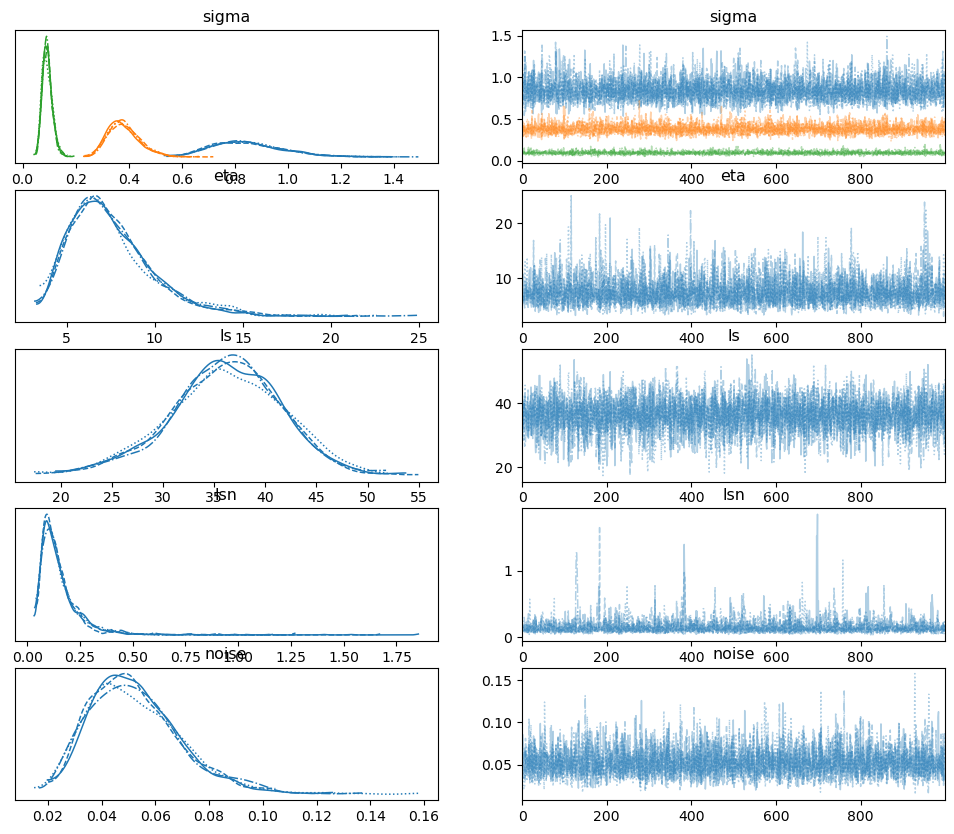

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [ ]:
_ = az.plot_trace(idata, show=True)
idata